In [2]:
import os
os.sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
from models.model_utils import Pl_model_wrapper
from models import models_with_args
import numpy as np
import random
import time
import pickle
from torch_geometric.loader import DataLoader
from datasets.cnf_data import Problem, Sat_datamodule, solve_sat, InMemorySATDataset
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
import tqdm


In [3]:
model_name = 'NeuroSAT'
checkpoint = '../temp/tb_logs/Final/version_0/checkpoints/epoch=32-step=891.ckpt'
data_path = '../temp/cnfs/selsam_3_40' 
num_iters = 1000
model_class = models_with_args[model_name]
loss_fn =  nn.BCEWithLogitsLoss()
model = Pl_model_wrapper(model_class, 
                -1, 
                -1,
                loss_fn,
                return_embs=True)
model = model.load_from_checkpoint(checkpoint)
model.eval()

folder_name = '../temp/cnfs/selsam_3_40/test/'
d = model_class['model_args']['d']
k = 20
# iterate of all problems in the folder, only the filenames with .dimacs extension are considered

def filter_files(folder_name,substr):
    filtered = []
    for file_name in tqdm.tqdm(os.listdir(folder_name)):
        if file_name.endswith(".dimacs") and substr in file_name:
            filtered.append(file_name)
    return filtered
filtered = filter_files(folder_name,"0040")

/home/jan/miniconda3/envs/torch18/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
100%|██████████| 10001/10001 [00:00<00:00, 2944905.53it/s]


In [5]:
# load processed_data
with open('../temp/processed_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)
    

In [6]:
from models.decimation import get_labeled_embs_and_votes
labeled_embs, num_wrong_clusterings, num_wrong_polarities, y_s = get_labeled_embs_and_votes(filtered, d, k, model, num_iters, folder_name,processed_data)

100%|██████████| 10000/10000 [02:14<00:00, 74.45it/s]


In [4]:
from models.decimation import get_processed_data
processed_data = get_processed_data(filtered, d, k, model, num_iters, folder_name)

100%|██████████| 300/300 [20:29<00:00,  4.10s/it]


In [49]:
with open('../temp/processed_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

In [7]:
# load cluster centers from pickle
with open('../temp/cluster_centers.pkl', 'rb') as f:
    cluster_centers = pickle.load(f)
cluster_centers

{'0': array([ 0.20627211,  0.03753444, -0.8254269 ,  0.94784266, -0.983828  ,
        -0.88671243, -0.91700083, -0.7195621 , -0.88072336, -0.9889268 ,
        -0.5877774 ,  0.9894349 ,  0.8523017 ,  0.69306135,  0.33591676,
        -0.73783845], dtype=float32),
 '1': array([-0.73830324,  0.03916041,  0.985295  , -0.71327347, -0.93077284,
         0.04568193, -0.64079416,  0.08947714, -0.92044157, -0.9001533 ,
        -0.9046818 ,  0.97906196, -0.02665108, -0.13030623,  0.8883731 ,
        -0.20505264], dtype=float32)}

In [7]:
from models.decimation import get_assignments_from_embs
assignments = get_assignments_from_embs(processed_data,cluster_centers)

In [8]:
from models.decimation import try_assignments_and_return_not_solved
not_solved,sat_assignments = try_assignments_and_return_not_solved(assignments)

In [16]:
len(not_solved)

13

In [10]:
287/len(assignments)

0.9566666666666667

In [52]:
4344/5000

0.8688

In [53]:
50/100*87

43.5

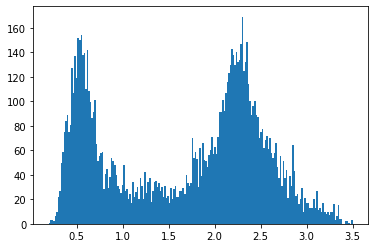

In [15]:
all_dists = []
for pr in not_solved:
    clauses = pr['clauses']
    assignments = pr['assignments']
    for assignment in assignments:
        dists = assignment[1]
        bools = assignment[0]
        all_dists.extend(dists)
        
import matplotlib.pyplot as plt
plt.hist(all_dists, bins=200)
plt.show()

In [14]:
from models.decimation import decimate, get_new_problems_from_decimation



dec_thresh = 1.9
solved_by_decimation = 0
nothing_was_decimated = 0
#unsuccessful_decimation = 0
new_problems = []
for pr in not_solved:
    new_problems_per_formula,was_decimated,is_sat = get_new_problems_from_decimation(pr,dec_thresh)
    if len(new_problems_per_formula)>0:
        new_problems.append(new_problems_per_formula)
    if not was_decimated:
        nothing_was_decimated+=1

    
print(solved_by_decimation)
print(nothing_was_decimated)
#print(unsuccessful_decimation)


152
0
2


In [14]:
# save new problems
with open('../temp/new_problems.pkl', 'wb') as f:
    pickle.dump(new_problems, f)

In [22]:
# load new problems
with open('../temp/new_problems.pkl', 'rb') as f:
    new_problems = pickle.load(f)

In [28]:
(4344+17+373)/5000

0.9468

In [29]:
50/100*94.7

47.35

In [23]:
from models.decimation import create_problem, process_one
def process_decimated(n_vars, clauses, d, k, model, num_iters):
    p,y = create_problem(n_vars, clauses, d, k)
    avg_votes = model.model(p,num_iters).detach()
    pred_binary = torch.sigmoid(avg_votes.squeeze()) >= 0.5
    majority = torch.mode(pred_binary).values.numpy()
    return majority

y_hats = []

model.model.return_embs = True
model.eval()

num_iters = 100
new_data = []
for multiple_decims in tqdm.tqdm(new_problems):
    formula_new_data = []
    for pr in multiple_decims:
        if pr['num_vars']==0:
            continue
        num_vars,clauses = pr['num_vars'],pr['clauses']
        res = process_one(num_vars, clauses, d, k, model, num_iters)
        formula_new_data.append(res)
    new_data.append(formula_new_data)


100%|██████████| 553/553 [26:08<00:00,  2.84s/it]


In [24]:
len(new_data)

553

In [43]:
with open('../temp/new_data_noncons.pkl', 'wb') as f:
    pickle.dump(new_data, f)

In [25]:
double_check = []
solved = 0
for dat in new_data:
    new_assignments = get_assignments_from_embs(dat,cluster_centers)
    new_not_solved,new_sat_assignments = try_assignments_and_return_not_solved(new_assignments)
    if len(new_sat_assignments)>0:
        double_check.append(new_sat_assignments[0])
        solved+=1
solved

373

In [27]:
from models.decimation import check_sat_assignment
passed = []
for i in range(len(double_check)):
    sol = double_check[0]['assignments'][0]
    clauses = double_check[0]['clauses']
    passed.append(check_sat_assignment(sol,clauses))
sum(passed)

373

In [31]:
preds = []
for file_name in tqdm.tqdm(filtered):
        n_vars, clauses = InMemorySATDataset.parse_dimacs(None,folder_name+file_name)
        p,y = create_problem(n_vars, clauses, d, k)
        y_s.append(y)
        votes = model.model(p,num_iters)
        pred_binary = torch.sigmoid(votes.squeeze()) >= 0.5
        # get majority vote
        majority = torch.mode(pred_binary).values
        preds.append(majority==y)

100%|██████████| 300/300 [00:17<00:00, 17.47it/s]


In [32]:
sum(preds)/len(preds)

tensor(0.8800)

In [24]:
print(f"number of wrong clusterings: {len(num_wrong_clusterings)} out of which {sum(num_wrong_clusterings)} were SAT")
print(f"number of wrong polarities: {len(num_wrong_polarities)}  out of which {sum(num_wrong_polarities)} were SAT")
print("percentage of SAT problems solved", (len(labeled_embs))/sum(y_s))

number of wrong clusterings: 76 out of which 54 were SAT
number of wrong polarities: 174  out of which 116 were SAT
percentage of SAT problems solved 0.8102


In [7]:
# save the labeled embeddings to pickle
import pickle
with open('../temp/labeled_embs.pkl', 'wb') as f:
    pickle.dump(labeled_embs, f)

In [3]:
# load the labeled embeddings from pickle
with open('../temp/labeled_embs.pkl', 'rb') as f:
    labeled_embs = pickle.load(f)

EOFError: Ran out of input

In [6]:
len(labeled_embs)

3825

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

means_0 = []
means_1 = []
for pr in labeled_embs:
    means_0.append(np.mean(pr[1]['0'],axis=0))
    means_1.append(np.mean(pr[1]['1'],axis=0))
means_all = means_0+means_1
# KMeans clustering
clusterer = KMeans(n_clusters=2, random_state=10)
cluster_labels = clusterer.fit_predict(means_all)
silhouette_avg = silhouette_score(means_all, cluster_labels)

In [10]:
from models.decimation import group_clusters
groups = group_clusters(means_all, cluster_labels)
zero_centers = np.mean(groups['0'],axis=0)
ones_centers = np.mean(groups['1'],axis=0)
cluster_centers = {'0':zero_centers, '1':ones_centers}
# save cluster centers to pickle
with open('../temp/cluster_centers.pkl', 'wb') as f:
    pickle.dump(cluster_centers, f)

In [13]:
# cosine distance between the two centers
# import cosine distance
from sklearn.metrics.pairwise import cosine_distances
cos_dis = cosine_distances([zero_centers], [ones_centers])
print('cosine distance between the two centers', cos_dis)
# euclidean distance between the two centers
eucl_dis = np.linalg.norm(zero_centers-ones_centers)
print('euclidean distance between the two centers', eucl_dis)

cosine distance between the two centers [[0.615767]]
euclidean distance between the two centers 3.2709422


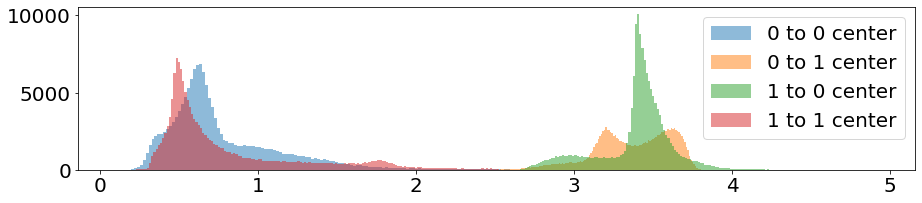

<Figure size 1080x216 with 0 Axes>

In [22]:
embs_0 = []
embs_1 = []
for pr in labeled_embs:
    embs_0 += pr[1]['0']
    embs_1 += pr[1]['1']

zero_lit_to_zero_center = []
zero_lit_to_one_center = []
one_lit_to_zero_center = []
one_lit_to_one_center = []
correctly_assisted_0 = 0
incorrectly_assisted_0 = 0
correctly_assisted_1 = 0
incorrectly_assisted_1 = 0
for i,emb in enumerate(embs_0):
    zero_to_zero_dist = np.linalg.norm(emb-zero_centers)
    zero_to_one_dist = np.linalg.norm(emb-ones_centers)
    zero_lit_to_zero_center.append(zero_to_zero_dist)
    zero_lit_to_one_center.append(zero_to_one_dist)
    if zero_to_zero_dist < zero_to_one_dist:
        correctly_assisted_0 += 1
    else:
        incorrectly_assisted_0 += 1
for i,emb in enumerate(embs_1):
    one_to_zero_dist = np.linalg.norm(emb-zero_centers)
    one_to_one_dist = np.linalg.norm(emb-ones_centers)
    one_lit_to_zero_center.append(one_to_zero_dist)
    one_lit_to_one_center.append(one_to_one_dist)
    if one_to_one_dist < one_to_zero_dist:
        correctly_assisted_1 += 1
    else:
        incorrectly_assisted_1 += 1

# plot histogram of distances
import matplotlib.pyplot as plt
# set the size of the image to be larger
plt.rcParams["figure.figsize"] = (15,3)
plt.rcParams.update({'font.size': 20})

plt.hist(zero_lit_to_zero_center, bins=200, alpha=0.5, label='0 to 0 center')
plt.hist(zero_lit_to_one_center, bins=200, alpha=0.5, label='0 to 1 center')
plt.hist(one_lit_to_zero_center, bins=200, alpha=0.5, label='1 to 0 center')
plt.hist(one_lit_to_one_center, bins=200, alpha=0.5, label='1 to 1 center')
plt.legend(loc='upper right')
# enlarge the font size
plt.show()
# save pdf
plt.savefig('../visualizations/histogram.pdf')

In [53]:
print('incorect 0:',incorrectly_assisted_0)
print('correct 0:',correctly_assisted_0)
print('incorect 1:',incorrectly_assisted_1)
print('correct 1:',correctly_assisted_1)


incorect 0: 17
correct 0: 152023
incorect 1: 3
correct 1: 152037
